In [1]:
import tensorflow.keras.applications.efficientnet as eff_net
from livelossplot.tf_keras import PlotLossesCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL

from pathlib import Path

In [2]:
path_base = r"D:\KWork\Project 1"

file_source = Path(path_base) / "base"
train_file_destination = Path(path_base) / "data" / "train"
val_file_destination = Path(path_base) / "data" / "validation"

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_data = ImageDataGenerator(preprocessing_function=eff_net.preprocess_input,
                              rotation_range=5,
                              width_shift_range=0.1,
                              height_shift_range=0.02,
                              zoom_range=0.15,
                              fill_mode="nearest")

BATCH_SIZE = 16
IMG_SHAPE = 128
IMAGE_SIZE = (128, 128, 3)

train_dir = train_file_destination
val_dir = val_file_destination

train_data_gen = gen_data.flow_from_directory(directory=train_dir,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              class_mode="sparse")

val_data_gen = gen_data.flow_from_directory(directory=val_dir,
                                            target_size=(IMG_SHAPE, IMG_SHAPE),
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            class_mode="sparse")

Found 3809 images belonging to 8 classes.
Found 1629 images belonging to 8 classes.


In [4]:
def get_compiled_model(dropout=0.2, lr=1e-4):
    import tensorflow as tf
    import tensorflow.keras.applications.efficientnet as eff_net
    
    base_model = eff_net.EfficientNetB7(include_top=False,
                                        weights="imagenet",
                                        input_shape=IMAGE_SIZE)
    base_model.trainable = False

    model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dropout(rate=dropout),
            tf.keras.layers.Dense(8, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

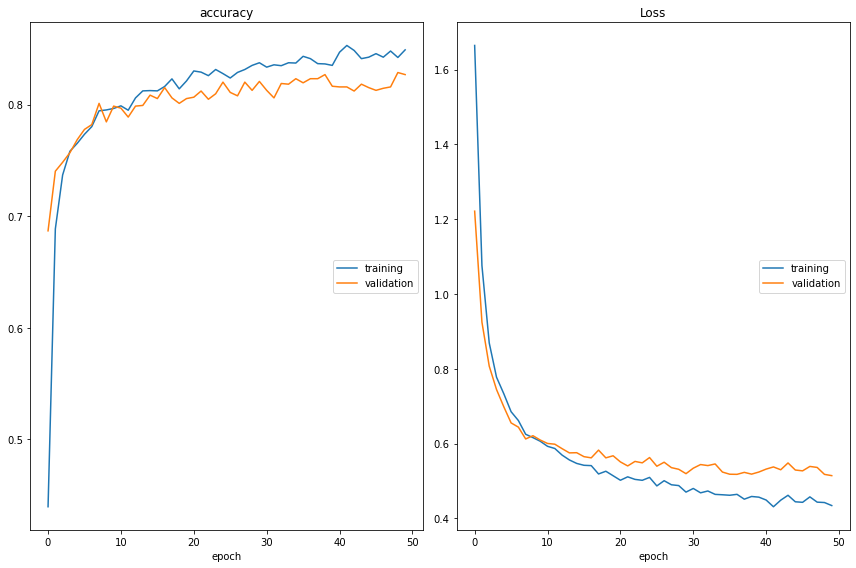

accuracy
	training         	 (min:    0.440, max:    0.853, cur:    0.849)
	validation       	 (min:    0.687, max:    0.829, cur:    0.827)
Loss
	training         	 (min:    0.431, max:    1.665, cur:    0.435)
	validation       	 (min:    0.515, max:    1.222, cur:    0.515)

Epoch 00050: val_accuracy did not improve from 0.82873


In [5]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(r"models/best_model.hdf5",
                                                monitor="val_accuracy",
                                                save_best_only=True,
                                                verbose=1,
                                                mode="max")

dropout_model = get_compiled_model(dropout=0.5, lr=1.5e-4)

EPOCHS = 50
dropout_model.fit(train_data_gen,
                    validation_data=val_data_gen,
                    epochs=EPOCHS,
                    callbacks=([PlotLossesCallback(), checkpoint]))